# DSCI 100 Group 36 Project Proposal

Soll Chi, Youchan Goh, Michael Qiu, Pawan Sekhon

## Title

Resting blood pressure and its effect on the type of chest pain a patient experiences

## Introduction

Heart disease is a disease that affects the heart and blood vessels. There are many types of heart disease, but we will be focusing on four main types. The first is typical angina. Typical angina is a temporary chest pain when your heart doesn’t receive enough blood or oxygen. Typical angina can be a symptom of coronary heart disease and is more common in men. The second is atypical angina, which is more subtle with its symptoms and can cause fatigue or shortness of breath. It can also cause discomfort in the throat, back, stomach, and other areas; the feeling is described as muscle pain and is more common in women. The third type is non-anginal pain. This is pain that a person without heart disease may feel behind their breast bone. This pain is caused by different reasons than typical angina, such as issues with the esophagus or lungs. The fourth type is asymptomatic heart disease. This is said to feel like heartburn but can have the same effects as a normal heart attack, causing blockage of blood flow and damage to heart muscles. Age and high cholesterol can contribute to asymptomatic heart attacks.

We will be using the  “processed.switzerland.data” which takes data from people from Switzerland such as the type of heart disease they have and other data such as sex, age, resting blood pressure, pain type, etc. Using this data, we will explore these types of heart diseases and answer the following question:

**Can the type of chest pain a patient feels be predicted based on resting blood pressure and maximum heart rate?**

## Preliminary Exploratory Data Analysis

In [3]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)
library(readr)

In [9]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cleveland <- read_csv(url)
names(cleveland) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                        "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num") 
head(cleveland)
tail(cleveland)
nrow(cleveland)

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


[1] 302

Table 1: Raw data from Cleveland which contains 302 rows of data. 

**Tidying Data**

In [5]:
cleveland_new <- subset(cleveland, trestbps != "?")

cleveland_new <- select(cleveland_new, age, sex, cp, trestbps, thalach) |>
    mutate(sex = ifelse(sex == 0, "male", "female")) |>
    mutate(cp = recode(cp, 
                     `1` = "typical angina",
                     `2` = "atypical angina",
                     `3` = "non-anginal pain",
                     `4` = "asymptomatic")) |>
    mutate(sex = as_factor(sex)) |>
    mutate(trestbps = as.numeric(trestbps)) |>
    mutate(cp = as_factor(cp))

cleveland_new <- mutate(cleveland_new, chestpain = as.factor(ifelse(is.na(cp), NA, (cp != "asymptomatic"))))

head(cleveland_new)

age,sex,cp,trestbps,thalach,chestpain
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
67,female,asymptomatic,160,108,FALSE
67,female,asymptomatic,120,129,FALSE
37,female,non-anginal pain,130,187,TRUE
41,male,atypical angina,130,172,TRUE
56,female,atypical angina,120,178,TRUE
62,male,asymptomatic,140,160,FALSE


Table 2: Wrangled and cleaned data containing variables of interest. Chest pain has been simplified to either no pain (FALSE) or pain (TRUE).

**Splitting Data**

In [7]:
set.seed(42)
cleveland_split <- initial_split(cleveland_new, prop = 0.75, strata = cp)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

nrow(cleveland_train)
nrow(cleveland_test)
cleveland_ratio <- nrow(cleveland_train)/(nrow(cleveland_train) + nrow(cleveland_test))
cleveland_ratio

[1] 226

[1] 76

[1] 0.7483444

**Summarizing Data Based on cp**

In [8]:
cp_count <- cleveland_train |>
    group_by(chestpain) |> 
    summarize(count = n()) 

**Visualizing Data**

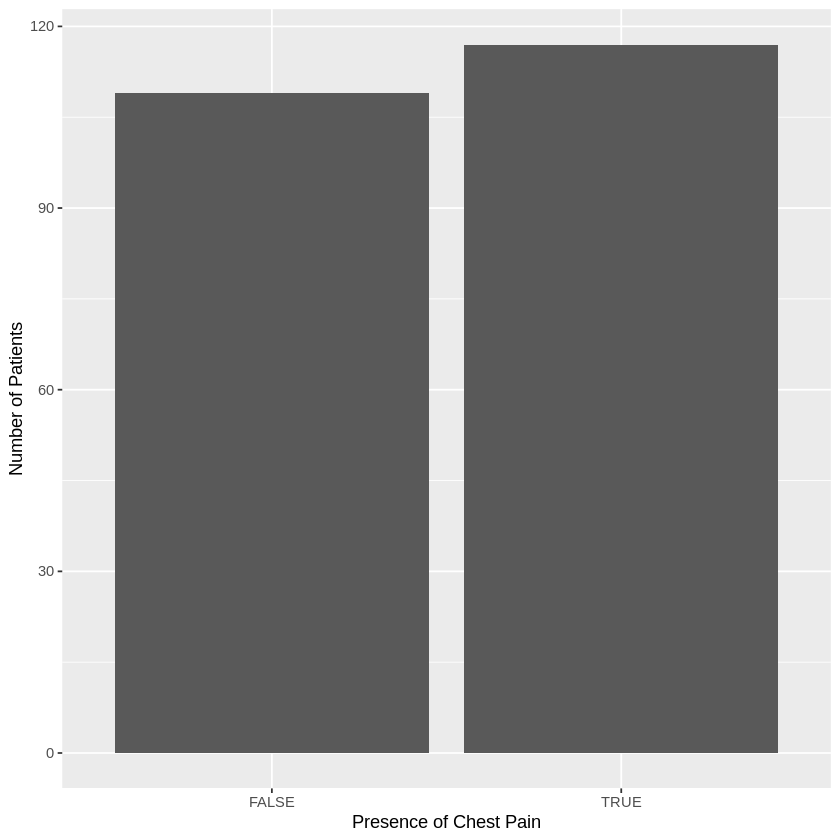

In [6]:
cp_plot <- cp_count |>
    ggplot(aes(x = chestpain, y = count)) +
                  geom_bar(stat = "identity") + 
                  labs(x = "Presence of Chest Pain", y = "Number of Patients")

cp_plot

Table 3: Visualization of the quantity of chest pain data. There is a relatively even split, so data was not balanced. 

**Visualizing the Relationship Between  Predictors and  Class**

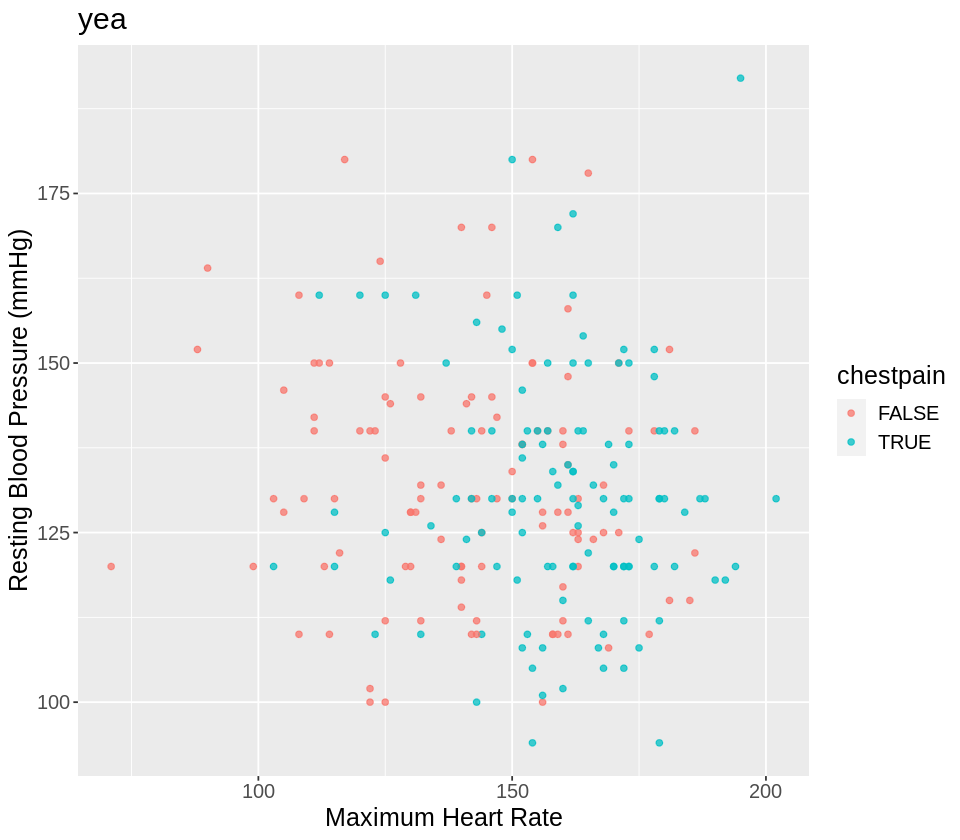

In [11]:
options(repr.plot.width=8, repr.plot.height=7)
cp_plot2 <- cleveland_train |>
    ggplot(aes(x = thalach, y = trestbps, color = chestpain)) +
    geom_point(alpha = 0.75) +
    xlab("Maximum Heart Rate") +
    ylab("Resting Blood Pressure (mmHg)") +
    ggtitle("yea") +
    theme(text = element_text(size = 15))
cp_plot2

Table 4: Visualization of the relationship between the explantory variables maximum heart rate and resting blood pressure based on chest pain type. 

**Training the Model**

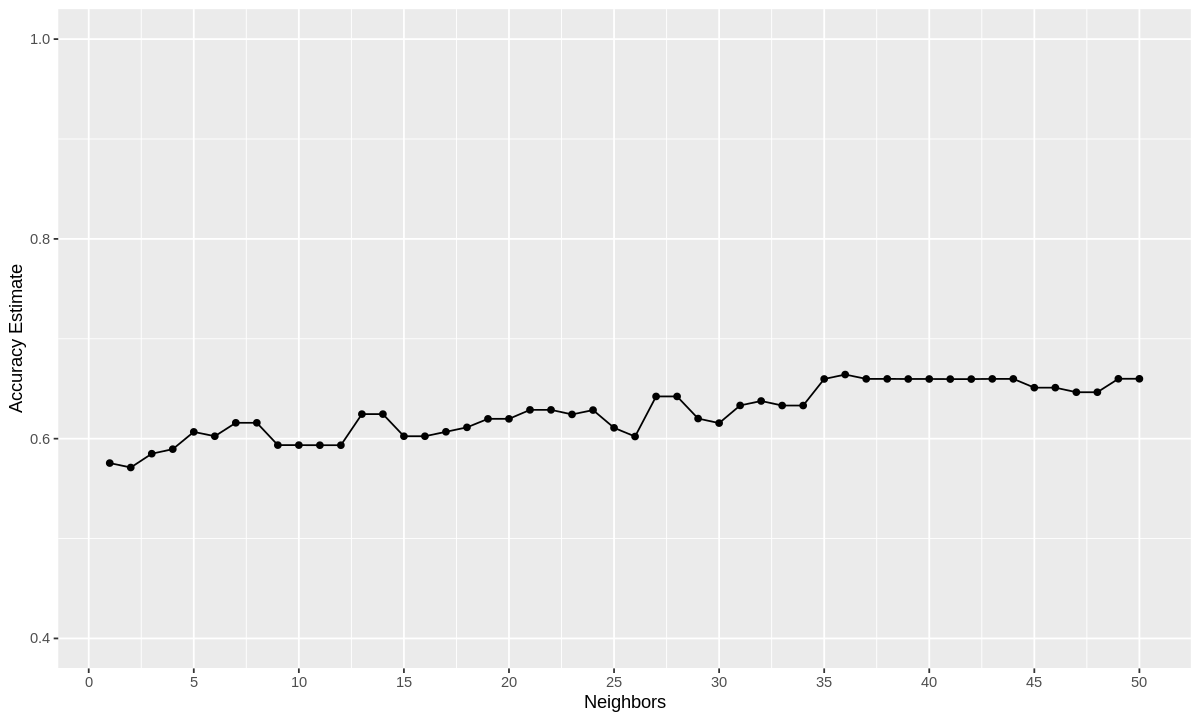

In [12]:
set.seed(42)
heart_recipe <- recipe(chestpain ~ thalach + trestbps, data = cleveland_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_vfold <- vfold_cv(cleveland_train, v = 5, strata = chestpain)

gridvals <- tibble(neighbors = c(1:50))

heart_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(knn_spec) |>
       tune_grid(resamples = heart_vfold, grid = gridvals) |>
       collect_metrics()

accuracies <- heart_fit |> 
       filter(.metric == "accuracy")

options(repr.plot.width=10, repr.plot.height=6)

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 5)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 

accuracy_versus_k

Table 5: Accuracy of different k values for a k nearest neighbor classification model. 

In [13]:
accuracies_table <- accuracies |>
    arrange(desc(mean))
head(accuracies_table)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
36,accuracy,binary,0.6641897,5,0.02158324,Preprocessor1_Model36
49,accuracy,binary,0.6599429,5,0.02536563,Preprocessor1_Model49
50,accuracy,binary,0.6599429,5,0.02536563,Preprocessor1_Model50
37,accuracy,binary,0.6598463,5,0.02042638,Preprocessor1_Model37
38,accuracy,binary,0.6598463,5,0.02042638,Preprocessor1_Model38
43,accuracy,binary,0.6598419,5,0.02460445,Preprocessor1_Model43


Table 6: Highest accuracy k values for k nearest neighbors classification model. 

In [16]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 36) |>
       set_engine("kknn") |>
       set_mode("classification")

best_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(best_spec) |>
       fit(data = cleveland_train)

best_fit

predictions <- predict(best_fit, cleveland_test) |>
    bind_cols(cleveland_test)

metrics <- predictions |>
    metrics(truth = chestpain, estimate = .pred_class)

metrics

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(36,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3628319
Best kernel: rectangular
Best k: 36

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6842105
kap,binary,0.3644599


Table 7: Accuracy of final k nearest neighbors model on test data. 

In [17]:
conf_mat <- predictions |> 
    conf_mat(truth = chestpain, estimate = .pred_class)
conf_mat

          Truth
Prediction FALSE TRUE
     FALSE    23   12
     TRUE     12   29

Table 8: Confusion matrix for predicted chest pain type using the test data.

## Methods

The variables used will be #3 age, #4 sex, #5 painloc (chest pain location), #9 cp (chest pain type), #10 trestbps (resting blood pressure). Using K-NN classification we will design a model that predicts the type of chest pain for a patient based on resting blood pressure, sex, age, and pain type.
We will generate a graph that plots the accuracy of our classification model.

## Expected Outcomes and Significance

We expect to find significant correlation levels between chest pain type and the resting blood pressure, age, and sex of the patient. Specifically, we expect to find that typical angina is more common in males and that atypical is more common in females

These findings can be used to discover potential treatments for heart disease and help doctors identify possible early signs of heart disease.

Some future questions could be:
- How do variables such as age and sex impact heart disease?
- What difference in men causes them to have typical angina more than women?
- What difference in women causes them to have atypical angina more than men?